# Practical Session - Unsupervised Learning

### Fait seul en français par **Abdennour Kerboua**


This Practical session is about unsupervised learning, and more specifically about dimensionality reduction using the PCA and ICA algorithms. You will first work on toy examples, and then apply the methods on a real face dataset.

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.cluster import KMeans

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm


import math

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from scipy.io import loadmat

# I - Toy examples
## I - 1) Dataset generation

As mentionned, you will first work on toy datasets. The next three functions are used to generate the data and plot the results.

In [2]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now,let's create the data we will use.
Try the 4 different scenarios by simply varying the `scenarioIndex` value between 1 and 4.

**Question** : what does each scenario corresponds to?

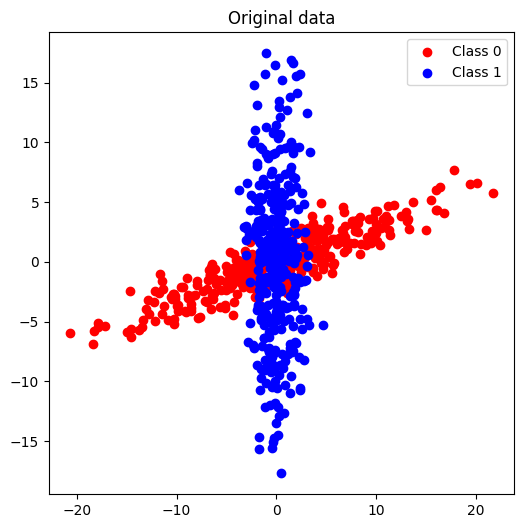

In [3]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

## I - 2) PCA

**BASIC PCA**

It's time to start using the methods seen in class. Let's start with PCA. 


As you can see, we have generated two populations (class 0 and class 1). We concatenate them as a single matrix *X* which will be the input for all methods. In this way, the methods will be unaware of the class of the observations (unsupervised) and we will test whether the methods are appropriate for the analysed scenario and if they are able to use less dimensions to correctly distinguish the two classes. 


**Question:**
1. Use PCA with the different 4 scenarios and comment the results. When does PCA work well ? Why ? Expain.

- La PCA permet de séparer les clusters en plus petite dimension seulement dans le **scénario 1** où les données sont séparables linéairement en les projetant selon la direction principale : les données suivent une gaussienne de moyennes très éloignées. De plus les covariances sont similaires (une classe a une direction principale oblique et l'autre a plusieurs directions privilégiés - matrice de covariance diagonale et coefficients égaux).

- Pour le **scénario 2**, les classes ne sont pas séparables linéairement : les données se superposent quand on les projette selon la direction principale car les moyennes des gaussiennes sont trop proches, même si les covariances sont proportionnelles et donc les directions de variation principales des deux classes identiques.

- Pour le **scénario 3**, les classes ne sont pas séparables linéairement car les moyennes sont trop proches et les covariances des deux classes sont trop différentes et donc l'échantillon global s'éloigne clairement d'une distribution gaussienne.

- Pour le **scénario 4**, les classes ne suivent pas une ditribution gaussienne et ne sont donc pas séparables linéairement.

The variance explained by the two first modes is respectively:  [0.65798097 0.34201903]


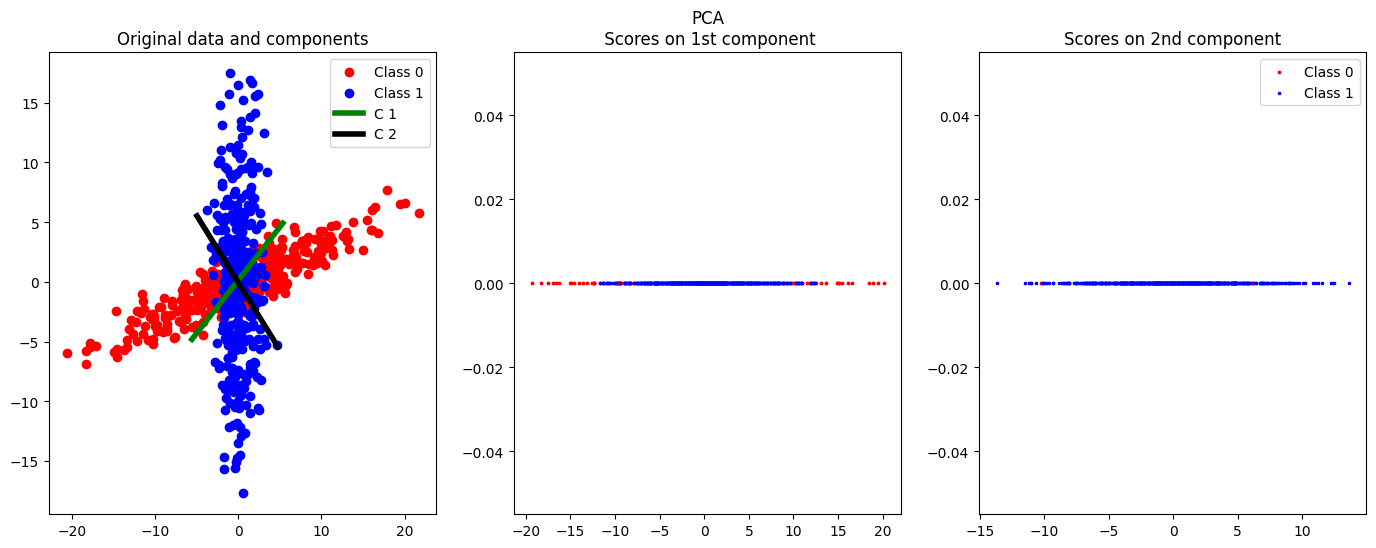

In [4]:
## PCA
pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
Ypca=pca.fit_transform(X)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

print('The variance explained by the two first modes is respectively: ', pca.explained_variance_ratio_)
plotResults(X0,X1,y,U,Ypca,const=1,title='PCA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [5]:
def pcaLecture(X):
    ''' 
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
              column consists of features.
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of X onto the new basis given by the eigenvactors U
            of the covariance matrix of X. Columns are the principal components.
               
            U: columns are Eigenvectors (sorted from the greatest to the lowest eigenvalue)
    
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)
               
            var_explained: percentage of the original variability explained
            by each principal component.
    '''
    
    N=X.shape[0]
    Xc=X - np.mean(X,axis=0) # centering
    _,D2, Uh = LA.svd(Xc) # computation of eigenvectors and eigenvalues using SVD
    #idx = np.argsort(D2)[::-1]  # indices of the sorted eigenvalues in descending order
    #print(D2[0:2])
    U = Uh.T #[:, idx]  # sorting eigenvectors according to the sorted indices of eigenvalues
    Y=(Xc@U)/(N-1) # computation of the scores
    D=D2**2/(N-1) # computation of the eigenvalues
    #print(D[0:2])
    tot=np.sum(D)
    var_explained = D/tot # computation of explained variance
    return Y,U,D,var_explained


**Question:**
1. Test your own implementation and check whether the results are the same of the scikit-learn implementation

On obtient les mêmes résultats qu'avec la PCA performé par scipy. 

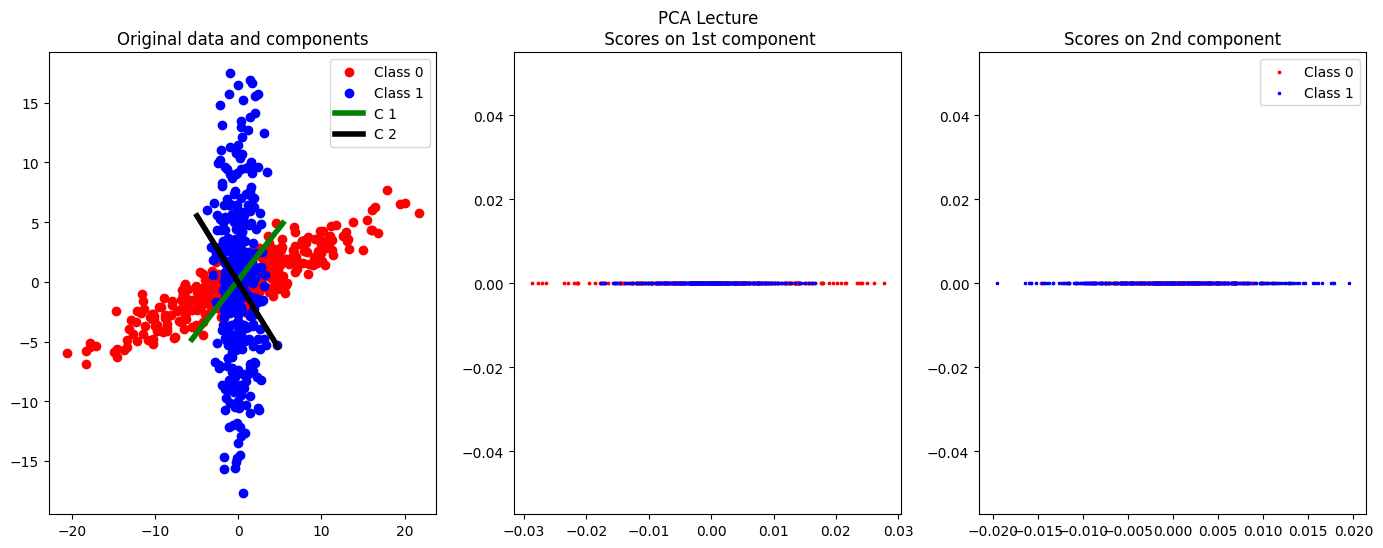

The variance explained by the two first modes is respectively:  [0.65798097 0.34201903]


In [6]:
YpcaLec,UpcaLec,DpcaLec,var_explainedPcaLec=pcaLecture(X)
plotResults(X0,X1,y,UpcaLec,YpcaLec,const=1,title='PCA Lecture')
print('The variance explained by the two first modes is respectively: ', var_explainedPcaLec)

**KERNEL PCA**

Let's now use Kernel-PCA with the rbf kernel (you can also test other kernels if you want).

**Question:**
1. What is the interest of kernel PCA over the basic PCA?

- **Answer** : La K-PCA projette les données dans un espace de plus grande dimension lorsqu'elle ne sont pas linéairement séparable dans l'espace d'origine. En etablissant une correspondance $\phi : \R^n \to \R^d$ (avec $n<d$) non linéaire entre l'espace d'origine et l'espace de plus grande dimension, les données (à la structure complexe et non séparables linéairement) deviennent linéairement séparable dans le nouvel espace.

2. Use Kernel-PCA with the different 4 scenarios and comment the results. When does K-PCA work well ? Why ?

- **Answer** : 
    - **scénario 1** : LA K-PCA fonctionne toujours, les donneés étaient déjà séparable par PCA simple.
    - **scénario 2 & 3** : Les données se chevauchés donc les mapper vers un autre espace est inutile et la K-PCA ne fonctionne donc pas.
    - **scénario 4** : La K-PCA permet de séparer les deux classes car les données ne se superposent pas et deviennent séparables dans le nouvel espace.


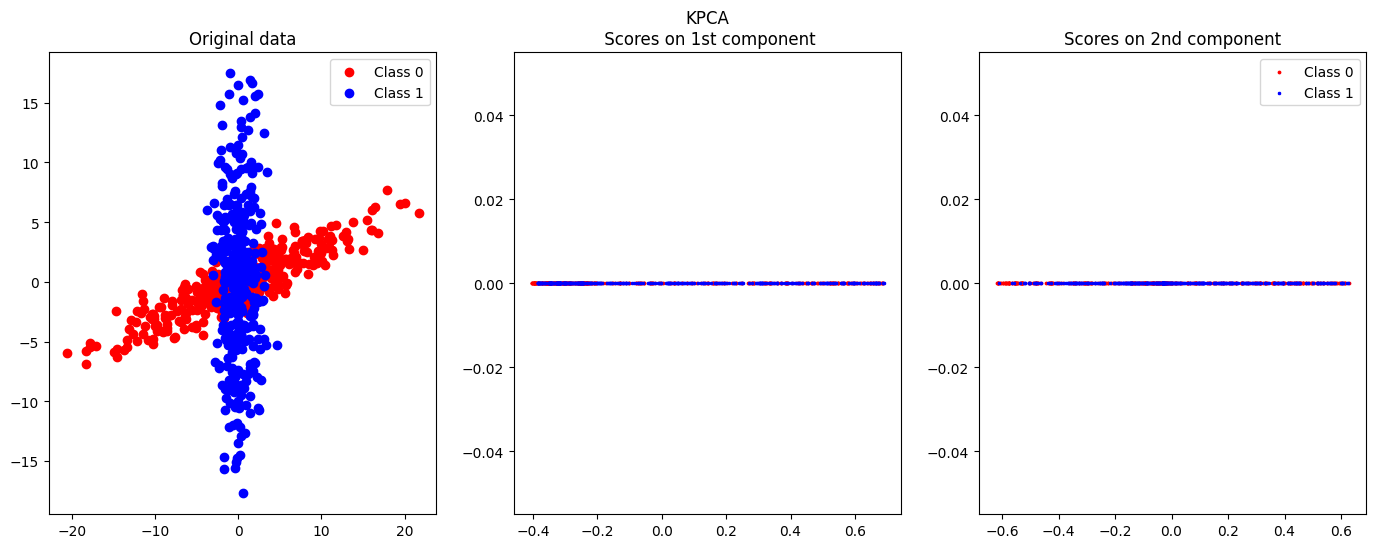

In [7]:
# Kernel-PCA
gamma= 0.1
Kpca = KernelPCA(kernel='rbf', gamma=gamma, random_state=1)
YKpca=Kpca.fit_transform(X)
DKpca=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

plotResults(X0=X0,X1=X1,y=y,Y=YKpca,const=1,title='KPCA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own ! Complete the code where you see **XXXXXXXXXXXXXX**

In [8]:
def KpcaGaussianLecture(X,gamma):
    '''  
    Inputs: 
            X: is a [Nxd] matrix. Every row is an observation and every
            column is a feature.
 
    Outputs:
            Y: is a [Nxd] matrix representing the scores, namely the 
            coordinates of \phi(X) onto the new basis given by the eigenvactors 
            of the covariance matrix of \phi(X). Columns are the principal components.

            An: columns are Eigenvectors normalised (sorted from the greatest
            to the lowest eigenvalue)
     
            D: Eigenvalues (sorted from the greatest to the lowest eigenvalue)

            var_explained: percentage of the original variability explained
            by each principal component.

    '''

    # kernel matrix using a rbf kernel 
    def kernel_matrix(X,gamma):
      N=X.shape[0]
      InnerX = np.dot(X,X.T)
      temp1=np.sum(X**2,axis=1).reshape((N,1))
      temp2=np.sum(X**2,axis=1).reshape((1,N))
      Norm1 = np.repeat(temp1,N,axis=1)
      Norm2 = np.repeat(temp2,N,axis=0) 
      Norm = Norm1+Norm2-2*InnerX;
      Norm[Norm<1e-10]=0;    
      K=np.exp(-Norm/(2*gamma**2))
      return K
       
    N=X.shape[0]

    K=kernel_matrix(X-np.mean(X,axis=0),gamma)
    
    # center kernel matrix
    oneN=np.ones((N,N))/N;
    Kc=K-oneN@K-K@oneN+oneN@K@oneN # center kernel matrix

    # eigenvalue analysis
    D,A=LA.eigh(Kc)     
    idx = D.argsort()[::-1]  # reverse order to make 'descend' 
    D = np.real(D[idx])
    D[D<0]=1e-18 # make negative eigenvalues positive (and almost 0)
    A = np.real(A[:,idx])

    # variance explained
    tot=np.sum(D)
    var_explained = D**2/((N-1)*tot) # computation of explained variance

    # Normalisation eigenvectors
    # Norm of every eigenvector is 1, we want it to be 1/sqrt(N*eig)
    
    An=np.copy(A)
    for i in range(N):      
        An[:,i]=np.dot(A[:,i],(1/np.sqrt((N-1)*D[i])) )          
           
    Y= Kc@An # computation of the scores  
    
    return Y,An,D,var_explained


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_4107/1181711373.py:2: SyntaxWarning: invalid escape sequence '\p'
  '''


Test your own implementation

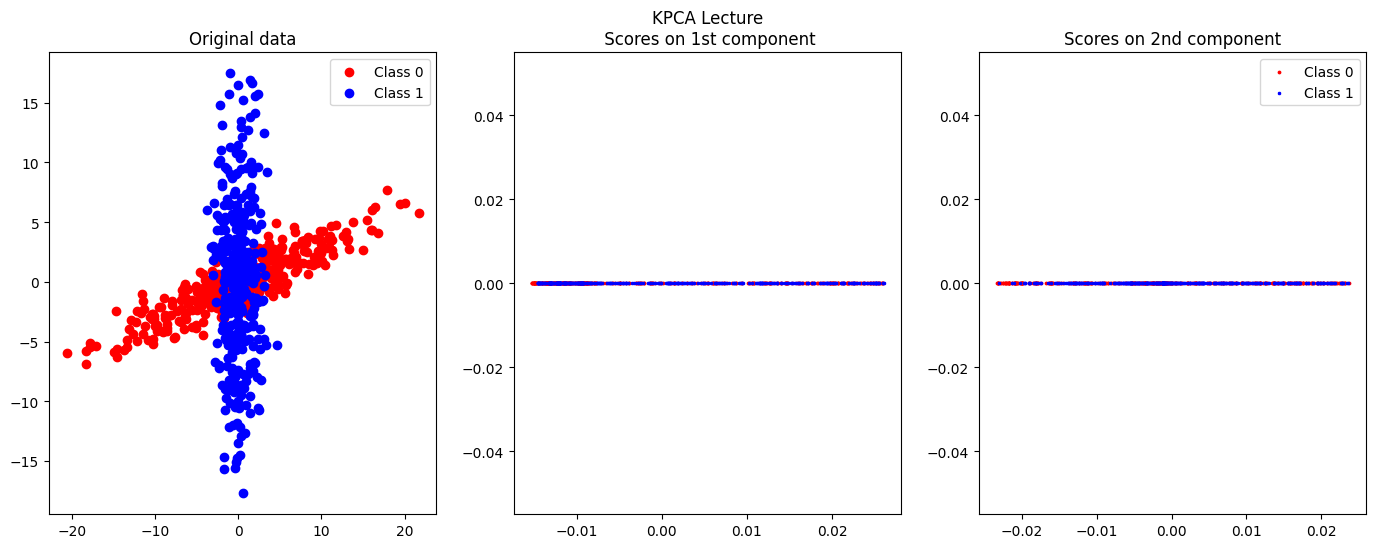

In [9]:
gamma_lecture = 1/(np.sqrt(2*gamma))
YKpcaLec, AnKpcaLec, DKpcaLec, var_explainedKpca = KpcaGaussianLecture(X,gamma_lecture) # Please pay attention to the fact that gamma is not the same in scikit implementation and ours. In scikit, gamma = 1/(2 sigma^2) and -gamma || x - y ||^2 is used
plotResults(X0=X0,X1=X1,y=y,Y=YKpcaLec,const=1,title='KPCA Lecture')

## I - 3) ICA

Now, we work on ICA, first by testing scickit-learn FastICA implementation, and then coding your own.

**Question:**
1. Use ICA with the different 4 scenarios and comment the results. When it works better than PCA ? Why ?

- Le résultat reste inchangé pour le **scénario 1** qui est résoluble par PCA : les données sont clairement séparables.
- **Scénario 2** (pas d'améliorations): les données ne sont pas séparables par l'ICA, les directions ne sont pas améliorés, l'ICA n'apporte pas d'améliorations car les données sont gaussiennes avec des covariances très proches. L'ICA fonctionne mieux avec des échantillons non-gaussiens.
- **Scénario 3** (améliorations) : l'estimation des directions de variations principales est clairement améliorée car les matrices de covariances sont très éloignées et donc l'échantillon global n'est pas gaussienne. L'ICA ne permet cependant pas la séparation des clusters, des données se chevauchent encore après projection car chaque classe reste gaussienne.
- **Scénario 4** (pas d'améliorations) : le résultat n'est pas améliorée car les données ne sont pas linéairement séparables.

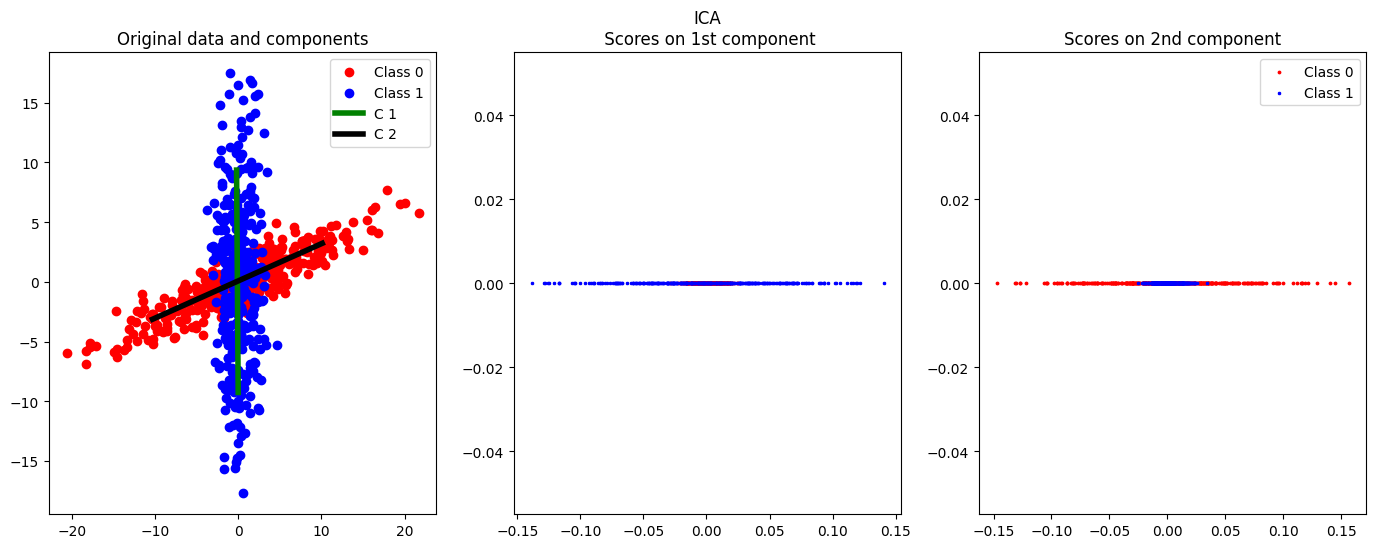

In [10]:
## ICA
ICA= FastICA(whiten='arbitrary-variance', fun='exp', max_iter=20000, tol=0.00001, random_state=1)
Yica=ICA.fit_transform(X)
Wica=ICA.mixing_
plotResults(X0=X0,X1=X1,y=y,U=Wica,Y=Yica,const=0.01,title='ICA')

**Question:**
1. Instead than using the scikit-learn implementation, implement one on your own !
Complete the code where you see **XXXXXXXXXXXXXX**

In [11]:
def FastICALecture(X,N_Iter=3000,tol=1e-5,plot_evolution=0):
    '''
    Inputs: 
                   X: is a [d x N] matrix. Every column is an observation 
                   and every row is a feature.       
    
                   (Optional) N_Iter: maximum number of iterations
    
                   (Optional) delta: convergence criteria threshold
    
                   (Optional) plot_evolution: plot evolution of error
                   
     Outputs:      
                   S: [d x N] matrix.  Each column is an independent component 
                   of the centred and whitened input data X              
                   
                   W: [d x d] matrix. It is the demixing matrix. S = W*Xcw 
    
    '''
    
    # We choose G=-exp(-1/2t^2)
    # First derivative of G   
    def g(t):
        res = t*np.exp(-t**2/2)
        return res
    
    # Second derivative of G  
    def gp(t):
        res = (1-t**2)*np.exp(-t**2/2)
        return res
    
    # Size of X
    d,N=X.shape 
    print(d,N)    
    # Compute sample mean
    mu = np.mean(X,axis=1)
    
    # Center data
    Xc=X-mu.reshape(d,1)
    
    # Compute covariance matrix
    C=np.cov(X)
    
    # Whiten data
    Xcw= LA.inv(LA.sqrtm(C))@Xc
    
    # check if are whitened
    if np.sum(np.eye(d) - np.abs(np.cov(Xcw)))>1e-10:
        raise NameError('Your whitening transformation does not work...')
    
    # Initialize W
    W = ortho_group.rvs(d) # random orthogonal matrix 
    # delta evolution
    k = 0
    delta = np.inf
    evolutionDelta=[]
    
    while delta > tol and k < N_Iter:
    
        k = k + 1
        W_old = np.copy(W)
        
        Wp = g(W@Xcw)@Xcw.T - np.diag(gp(W@Xcw)@np.ones(N))@W
        W = LA.inv(LA.sqrtm(Wp@Wp.T))@Wp
        if np.sum(np.eye(d)-np.abs(np.dot(W,W.T)))>1e-10:
            raise NameError('W should be an orthogonal matrix. Check the computations')
                 
        delta = 1-np.min(np.abs(np.diag(np.dot(W.T,W_old))))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration ICA number ', k, ' out of ', N_Iter , ', delta = ', delta)
     
        
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')


    # Independent components
    S = W@Xcw

            
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - ICA')
        plt.show()
       
    return S,W,Xcw


Test your own implementation

2 700
Iteration ICA number  1  out of  10000 , delta =  0.30243449739739703
Iteration ICA number  100  out of  10000 , delta =  1.2219397715895752e-09
Iteration ICA number  200  out of  10000 , delta =  4.440892098500626e-16
Convergence achieved ( delta =  0.0 ) in  202  iterations


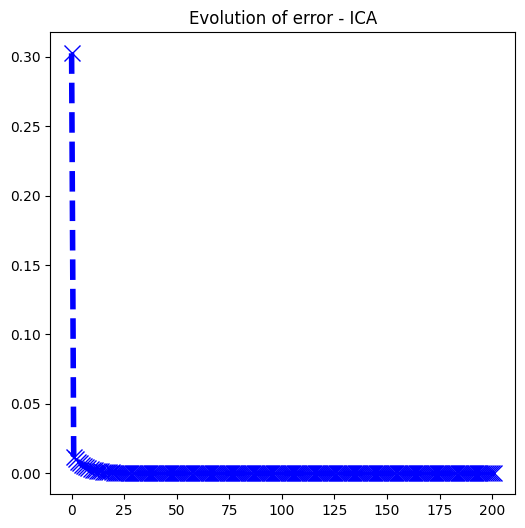

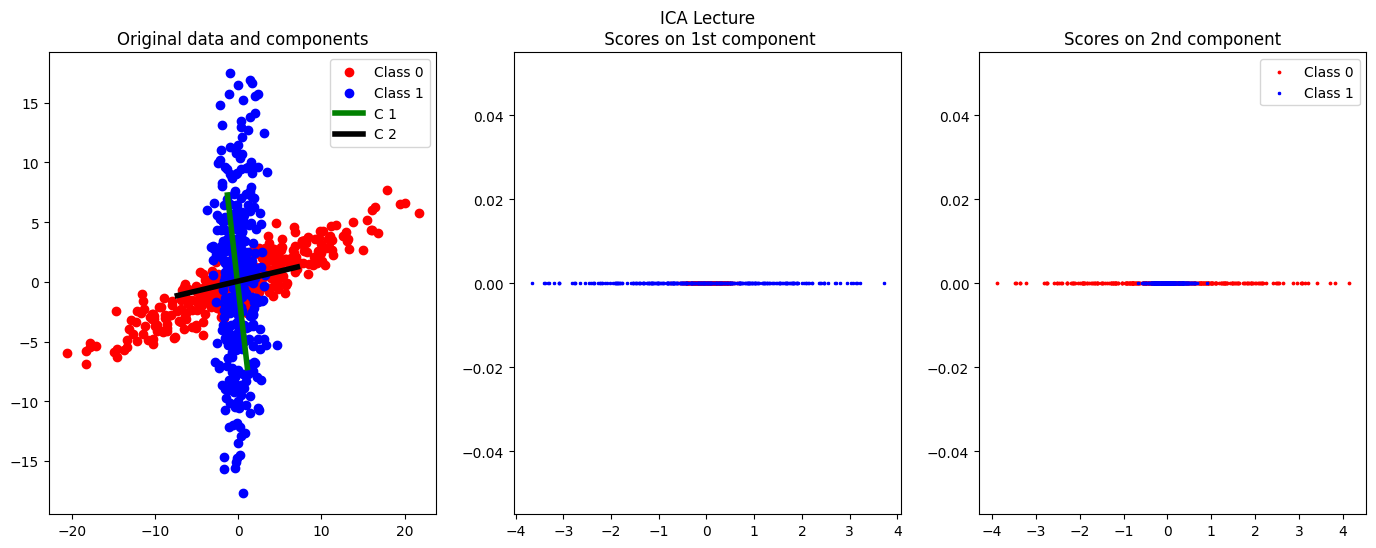

In [12]:
SicaLec,WicaLec,Xwh = FastICALecture(X.T,N_Iter=10000,tol=1e-20,plot_evolution=1)
plotResults(X0=X0,X1=X1,y=y, U=WicaLec.T, Y=SicaLec.T, const=1, title='ICA Lecture')


# II - True image dataset and face recognition
## II - 1) Dataset

**Goal**
The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning as a preprocessing for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

Let's load the data.

In [13]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory=""   

You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data


Below is a useful function to plot the basis images. Be careful, each row of data is a basis image.

In [14]:
def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())
  

Let's load the data and compute some parameters.

In [15]:
x = loadmat(Working_directory + 'YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')

FileNotFoundError: [Errno 2] No such file or directory: 'YaleB_32x32.mat'

Let's plot first 10 images of different subjects and then 10 images of the same subject but with different positions and illumination conditions

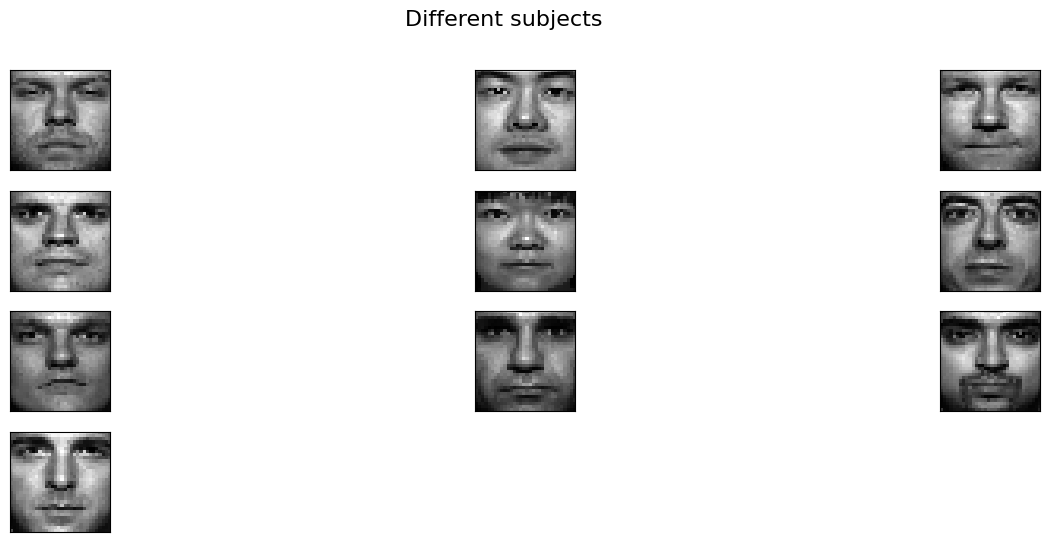

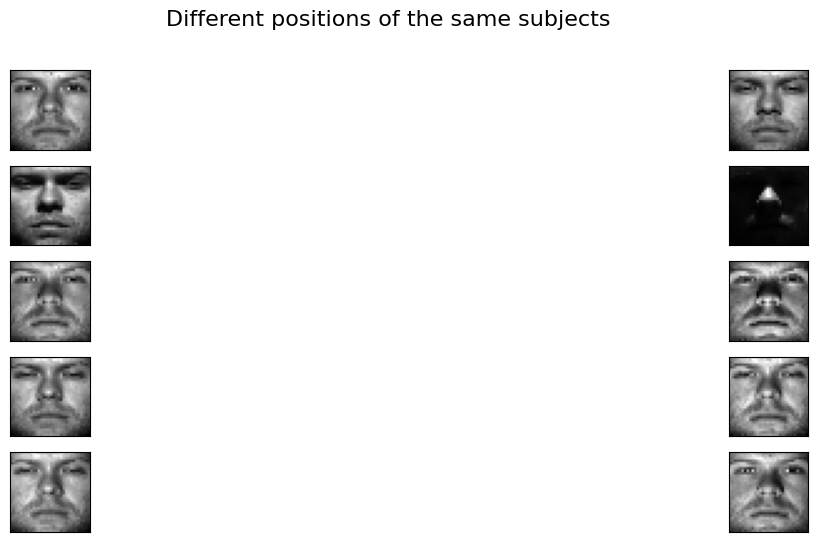

In [ ]:
# Plot data      
indexDifferent=np.arange(1,Is*40,Is)     
plotFaces(data,r,c,ncol=3,indeces=indexDifferent[0:10],title='Different subjects')       
indexSame=np.arange(0,10,1)      
plotFaces(data,r,c,ncol=2,indeces=indexSame,title='Different positions of the same subjects')       


We can now move on to evaluate the  performance of the dimensionality reduction techniques presented this morning for face recognition. We first divide the data-set into two parts, training (80%) and test (20%) in a stratified way (subjects are divided in a balanced way between the two parts).

We will see in the next lectures why we need to divide into training and test sets. For now, just know that we will use the first set to train our algorithm and the second set to test the performance of our algorithm on new, unseen data.



In [ ]:
Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest= Xtest - np.mean(Xtest,axis=0) # centering
Xctrain= Xtrain - np.mean(Xtrain,axis=0) # centering

As first idea, we could simply use the pixel intensities as features for the classification. This is basically like using the original data, without dimensionality reducton techniques.
In the following, we will use the nearest-neighboor algorithm to perform the classification task. For each test sample, the nearest neighbor algorithm simply looks for the closest training sample and then assigns the same label (i.e. index of subject).

In [ ]:
## Use the pixel intensities to find the correct subject for the test images
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(Xctrain,Id_Train.ravel())
print('By using the pixel intensities, we use ', Xctrain.shape[1], ' features')
print('Percentage of correct answer using the pixel intensities is ', NN.score(Xctest,Id_Test))



By using the pixel intensities, we use  1024  features
Percentage of correct answer using the pixel intensities is  0.7412008281573499


# II - 2) PCA
**Preliminary part:** We can use PCA to investigate the main variations within the data.

**Question:**
1. How many modes do you need to explain at least 80% of the variability in the data ? 

**Answer** : Pour exmpliquer au moins 80% de la variance il faut considérer les 5 premiers modes de variation (on explique 80,381% de la variance avec ces modes).

2. Look at the three main modes and explain which are the main variations in the data.

**Answer** : La morphologie des visages ne semble pas changer avec les 3 premiers modes. Ces modes expliquement majoritairement l'éclairage et le contraste. 
- **Mode 1** : Contraste, radiométrie
- **Mode 2** : Orientation de l'éclairage (par la droite ou la gauche)
- **Mode 3** : Intensité lumineuse sur l'ensemble du visage (surtout sur les joues)

The variance explained by the first 10 modes is respectively:  [35.94552474 71.15662119 76.02288771 78.84903197 80.38194051 81.79300845]


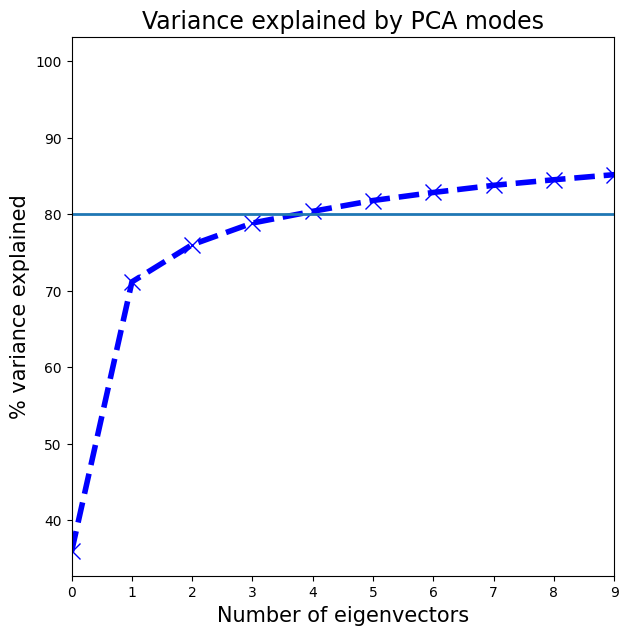

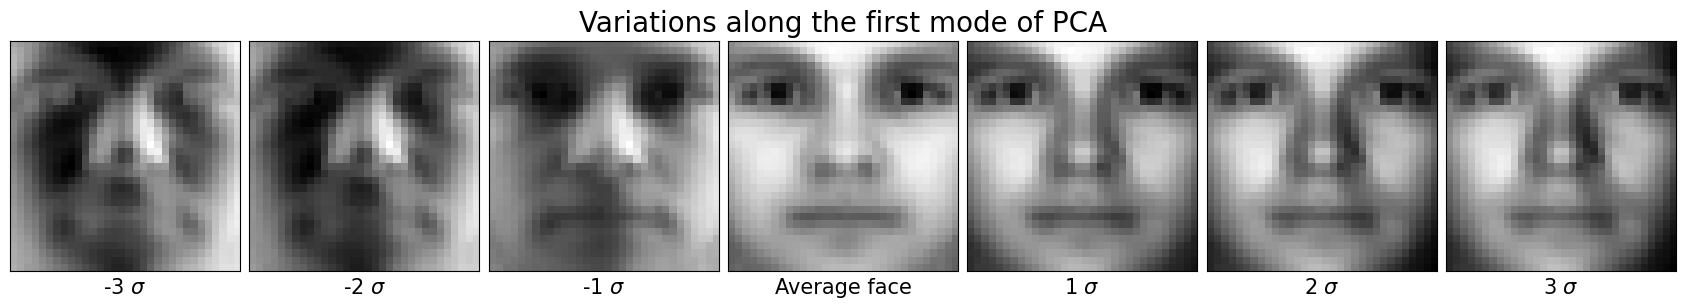

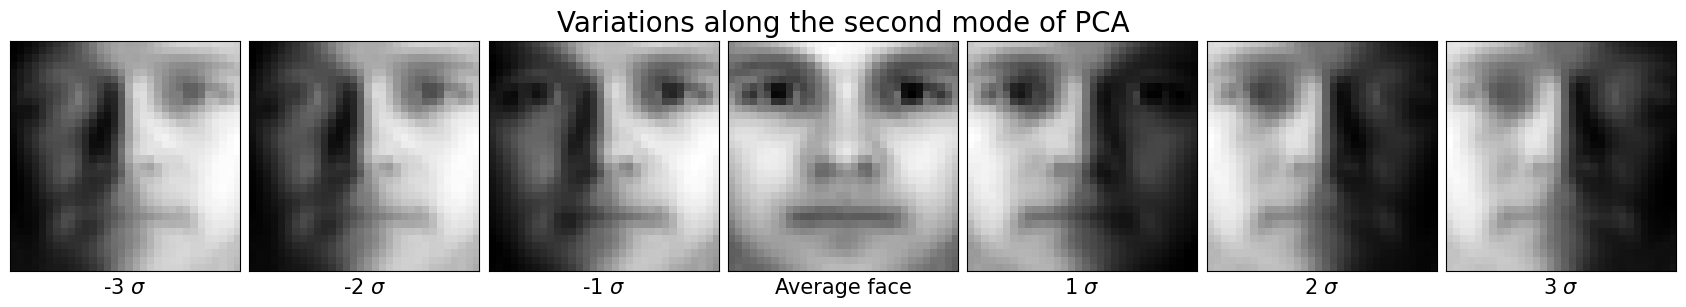

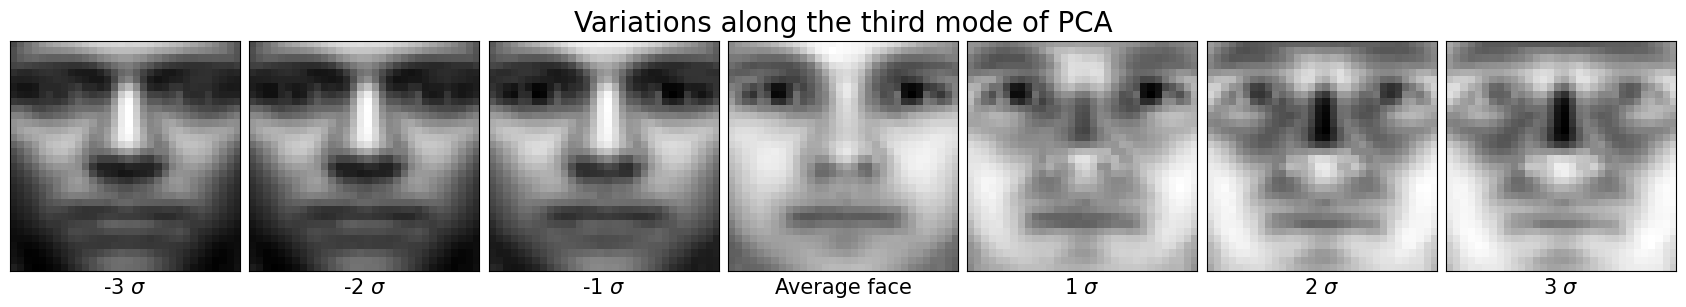

In [ ]:
# Linear interpolation along the first two modes
Xm=data.mean(axis=0) # average face
YpcaTrain,UpcaTrain,DpcaTrain,var_explained_pca=pcaLecture(data)
indices=np.linspace(-3, 3, num=7, dtype=np.int16) # Interpolation indices

# Variance explained by each eigenvector
fig=plt.figure(figsize=(7, 7))
ax=plt.subplot(111)
ax.set_xlim(0, 9)
dim=np.arange(0,10,1)
lim = np.array([80]*10)
plt.plot(np.cumsum(var_explained_pca*100),'bx--', linewidth=4, markersize=12)
print('The variance explained by the first 10 modes is respectively: ', np.cumsum(var_explained_pca*100)[0:6])
plt.plot(lim,linewidth=2)
plt.xticks(dim)
plt.xlabel('Number of eigenvectors',fontsize=15)
plt.ylabel('% variance explained',fontsize=15)
plt.title('Variance explained by PCA modes',fontsize=17)

## First mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the first mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[0])*UpcaTrain[:,0]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)


## Second mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the second mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[1])*UpcaTrain[:,1]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

## Third mode
fig=plt.figure(figsize=(17, 3))
plt.suptitle('Variations along the third mode of PCA', size=20)
for i, index in enumerate(indices):
  image = Xm + index*np.sqrt(DpcaTrain[2])*UpcaTrain[:,2]
  fig.add_subplot(1, len(indices), i+1)
  plt.imshow(np.resize(image,(r,c)).T,origin='upper',cmap='gray')
  if index != 0:
    plt.xlabel(r'%i $\sigma$' %index, fontsize=15)
  else:
    plt.xlabel('Average face', fontsize=15)
  plt.xticks(())
  plt.yticks(())
  plt.subplots_adjust(left=0.01, bottom=0.05, right=0.99, top=0.93, wspace=0.04, hspace=0.0)

**PCA as a preprocessing for classification:**

Now, we can employ PCA as a preprocessing step before classification. You will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 




Precisely, using PCA, compute the scores $Y_{train}$, eigenvectors $U_{train}$ and eigenvalues $D_{train}$ of the training set. The eigenvectors $U_{train}$ represent the basis images and they are usually called *'Eigenfaces'*. Then, project both training and test data onto the eigenvectors that explain 99$\%$ of the variability of the training set $L_{train}^{99}$. You will obtain two vectors of scores, $Y_{train}^{99}=X_{train} L_{train}^{99}$ and $Y_{test}^{99}=X_{test} L_{test}^{99}$, which you will use for evaluating the performance of the algorithm. Use the function `KNeighborsClassifier` to test the performance.

**Practical Questions:** 

1. Use the scikit-learn implementation to test the performance, as previously explained. Furthermore, please comment the eigenfaces. Do they seem "real" ?

**Answer** : Seule un visage semble réel, les autres semblent synthétisés. Ce qui était prévisible, ils doivent être élémentaires et synthétiques pour expliquer les variations du dataset et servir de base de décomposition.
**Theoretical Questions:** 

1. In your opinion, why do we need to center the data before computing a PCA ? If you want, you can use the previous toy examples to answer this question.

**Answer** : Il est important de centrer les données pour éliminer l'influence de la moyenne. En ne centrant pas, et avec une moyenne importante, la première direction serait celle de la moyenne par rapport à l'origine. Si l'origine n'est pas la moyenne, on ne mesure pas la variance entre les données mais des données par rapport à l'origine ce qui biaise le calcul des modes et ne permet pas d'apprendre les principales variations des données.

2. Let $X$ be the original data, a matrix $\left[ N,d \right]$, and $Y$ the scores of a PCA keeping all eigenvectors, which means that $Y$ is also a matrix $\left[ N,d \right]$. Are $X$ and $Y$ equal ? If not, why ? What would you use (generally speaking) in a machine learning problem ? Why ?

**Answer** : Non, $X$ et $Y$ ne sont pas égaux mais on passe facilement de l'un à l'autre en mutlipliant par la matrice inverse des vecteurs propres. $Y$ correspond aux images d'origine après un changement de base. Même si les deux matrices sont équivalentes, on peut préférer $Y$ dans la nouvelle base des vecteurs propres de la PCA car cette nouvelle base explique mieux les variations entre les images et pourrait améliorer l'apprentissage mais cela n'aporte aucun gain en coût de calcul.

3. Let $x_p$ and $x_q$ be two row-vectors representing two images, $U$ an *orthogonal* matrix whose columns are the eigenvectors of $X$ and $y_p=x_pU$, $y_q=x_qU$, check that $x_px_q^T=y_py_q^T$. This shows that $Y=XU$ is a linear transformation that preserves inner products.

**Answer** : On pose le calcul qui donne, $$ y_py_q^T = x_pU(x_qU)^T = x_pUU^Tx_q $$  Or $U \in \mathcal{O}(N)$ donc $UU^T = I_N$ et donc : $y_py_q^T = x_pI_Nx_q = x_px_q$

4. Let $C$ be the covariance matrix of $X$ and $C=UDU^T$ its eigen decomposition. Show that the covariance matrix of $Y=XU$ is $D$.

$$E(Y^TY) = E(U^TX^TXU) = U^T E(X^TX)U = U^TCU = U^TUDU^TU \overset{U \text{orthogonale}}{=} D$$


PCA uses  233  features
Percentage of correct answer using PCA is  0.7122153209109731


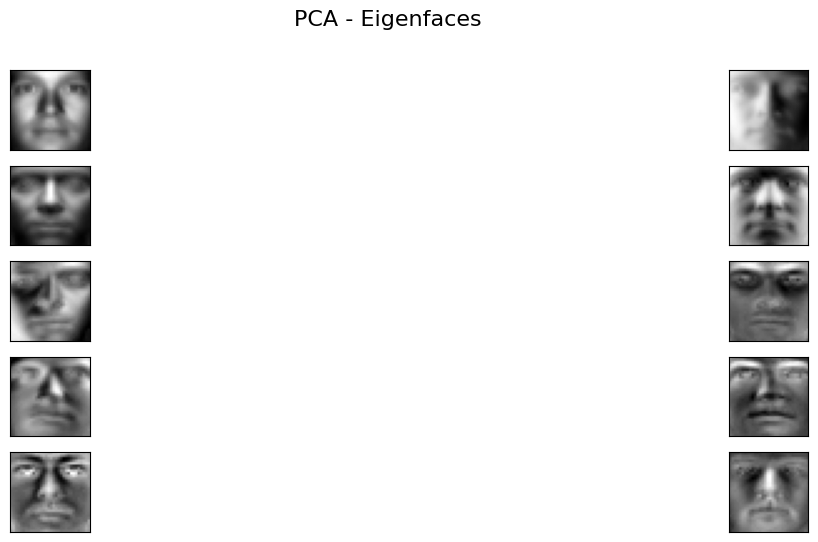

In [ ]:
## PCA (scikit-learn implementation)
pca = PCA(random_state=1)
Yr_train_PCA=pca.fit_transform(Xctrain)
U=pca.components_.T # we want PC on columns
D = (pca.singular_values_)**2/(X.shape[0]-1) # computation of the eigenvalues

var_explained_pca = np.cumsum(pca.explained_variance_ratio_)
PCAComp = np.argmax(var_explained_pca>0.99)+1
print()

# Threshold defined as 99% of the variability

print('PCA uses ', PCAComp, ' features')

# Selection of the eigenvectors 
L99 = U[:,0:PCAComp]

# Computation of the test scores using the eigenvectors computed with the
# training data-set

Yr_test_PCA = Xctest@L99

# Plot the Eigenfaces
plotFaces(L99.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='PCA - Eigenfaces')       

# Score: apply the nearest-neighboor algorithm to PCA output
NN.fit(Yr_train_PCA[:,0:PCAComp],Id_Train.ravel())
print('Percentage of correct answer using PCA is ', NN.score(Yr_test_PCA,Id_Test))



**KPCA**

In this section, we are going to do exactly the same procedure as before but using Kernel-PCA with a Gaussian kernel. Remember that we need to compute and center the test kernel matrix $[\mathbf{\tilde{K}}]_{ij}=<\phi(x_i)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)>$ and that, once computed the basis vectors in the training set $\{  \mathbf{\alpha}_i \}$, we can compute the score for a test sample $t$ using the following equation:

$y_i(t) = \sum_{j=1}^N a_{ij} <\phi(t)-\frac{1}{N} \sum_{s=1}^N \phi(x_s),\phi(x_j)-\frac{1}{N} \sum_{s=1}^N \phi(x_s)> = \sum_{j=1}^N a_{ij} \tilde{k}(t,x_j)$

Answer the following questions:

**Questions:** 

1.  Use the scikit-learn implementation to test the performance
2. Look for the best gamma value

**Answer** : $\gamma = 4.5$ semble donner un résultat optimal en utilisant l'implémentation scikit.

3. Why the basis vectors $\{  \mathbf{\alpha}_i \}$ are not plotted as in PCA ?

**Answer** : Ils sont calculés dans l'espace de plus grande dimension qui n'a pas de sens physique (ensemble de pixels) mais qui ne sert que pour la classification. En bref, ce ne sont pas des images de l'espace d'origine, ils n'expriment les variations principales des images d'origines.

4. Is it worth it, in your opinion, to compute PCA and/or KPCA ? Why not using the original pixel intensities ? Please consider the following aspects in your answer: performance, computational time, number of features, and interpretability of the results.

**Answer** : Pour des images de grandes dimensions (e.g 1024x1024p) il devient très vite très coûteux en terme de coût matériel et temporel d'entraîner un classificateur ou un réseau de neurone (la mémoire vive nécessaire avoisine souvent la centaine de gigaoctets). Réduire le nombre de composantes (comme ici quasiment par 3) réduit drastiquement le temps de calcul et le coût matériel tout en permettant une efficacité très similaire au traitement de l'ensemble des composantes (baisse d'efficatité d'à peine 3 centièmes).

Cela améliore aussi évidemment l'interprétabilité de l'apprentissage en permettant d'observer les variations principales et pertinentes des données au lieu de se limiter aux variations canoniques.

5. (Optional) Create a new function `Kpca_poly_lecture` where you change the kernel to $k(x,y)=<x,y>^d$. Evaluate the performance of this new kernel.


In [293]:
# Kernel-PCA (scikit-learn implementation)
## choose a gamma value
gamma=4.5
#
# Apply K-PCA 
Kpca = KernelPCA(kernel='rbf',gamma=gamma,random_state=1)
Yr_train_KPCA=Kpca.fit_transform(Xctrain)
lambdas=Kpca.eigenvalues_
AKpca=Kpca.eigenvectors_

# variance explained
var_explained = lambdas / np.sum(lambdas)
var_explained_KPCA = np.cumsum(var_explained)

# Threshold defined as 99% of the variability
KPCAComp = np.argmax(var_explained_KPCA>0.99)+1

# Selection of the eigenvectors 
L99 = AKpca[:,0:KPCAComp]

# Construction matrix K for test
N = Xctrain.shape[0]
M = Xctest.shape[0]
InnerX = np.dot(Xctest,Xctrain.T)
tempTrain=np.sum(Xctrain**2,axis=1).reshape((1,N))
tempTest=np.sum(Xctest**2,axis=1).reshape((M,1))
NormTrain2 = np.repeat(tempTrain,M,axis=0)
NormTest2 = np.repeat(tempTest,N,axis=1) 
Norm = NormTest2+NormTrain2-2*InnerX
Norm[Norm<1e-10]=0    
Ktest=np.exp(-Norm/(2*gamma**2))

# Centering kernel test matrix
oneN=np.ones((N,N))/N
oneM=np.ones((M,M))/M
KcTest= Ktest-oneM@Ktest-Ktest@oneN+oneM@Ktest@oneN # center kernel matrix 
       
# Computation of the test scores using the eigenvectors computed with the training data-set        
Yr_test_KPCA= KcTest@L99

print('KPCA uses ', Yr_train_KPCA.shape[0], ' features')


# Score
NN.fit(Yr_train_KPCA[:,0:KPCAComp],Id_Train.ravel())
print('Percentage of correct answer using KPCA is ', NN.score(Yr_test_KPCA,Id_Test.ravel()))



KPCA uses  1931  features
Percentage of correct answer using KPCA is  0.6376811594202898


# II - 3) ICA (optional part)

In the next section you will evaluate ICA. Every image $x_i$ can be seen as a linear combination of basis images. ICA can be used in two different ways for face recognition. We can look for a set of statistically independent basis images $s_j$ (first architecture) or for a set of statistically independent coefficients $a_{j}$ (second architecture).

In the first architecture, we compute $X'=A'S'$, where every row of $X'$ is an image and the columns are pixels. Images are considered as random variables and we look for a set of statistically independent basis images contained in the rows of $S'$.

In the second architecture, we transpose the previous setting computing $X''=A''S''$, where every column of $X''$ is an image and rows are pixels. In this case, we consider the pixels as random variables and we look for a set of statistically independent coefficients contained in the rows of $S$ and a set of basis images in the columns of $A$.

Instead than using the original training data $X$ as input matrix, we are going to use the eigenvectors (first architecture) or the scores (second architecture) computed with PCA, namely $Y=XL$ (same notation as in the slides of the lecture). In this way, we reduce the computational time since the number of eigenvectors that account for 99\% of the variance of the training images (columns of $L$) is definitely lower than the number of pixels (columns of $X$). If you want, you can of course use the original data but it will take much more time to converge.

For the first architecture we will use $L^T$ as input matrix. In fact, we can notice that the PCA approximation of the matrix $X_{train}$, containing an image in every row, can be written as $\tilde{X} = YL^T$. If we use $L^T$ as input in the ICA algorithm we obtain $L^T=AS$, thus it follows that $\tilde{X}=YW^TS$ (since $A=W^{-1}=W^T$). The basis images are contained in the rows of $S$ and the coefficients used for evaluating the performance are instead contained in the rows of $Y_{train}W^T$ for the training set and in $Y_{test}W^T$ for the test set.

For the second architecture, we will instead use $Y^T$ as input matrix thus obtaining $Y^T=AS$. Remember that in the second architecture we want to apply the ICA algorithm to the transpose of $X_{train}$. We can notice that, given the PCA transformation $Y=XL$, one can write $X \approx YL^T$ which entails $X^T \approx LY^T=LAS=LW^TS$. The columns of $LW^T$ contain the basis images whereas the columns of $S$ contain the statistically independent coefficients used to test the performance of the algorithm. The coefficients for the test set are in the columns of $S_{test}=W_{train}Y_{test}^T$.

NB: Here we used $X=X_c$ which means centered face images

**Questions:**
 
1. Use the scikit-learn implementation to test the performance of the two architectures
2. Look at the results of the two architecures. Which one is better ?
3. Looking at the basis images, in which case do they seem more 'real' ?



In [ ]:
#first architecture (scikit-learn implementation)
# First apply PCA as a preprocessing for ICA
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

# We use the PCA projection to speed up results
# Threshold defined as 99% of the variability
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

# Selection of the eigenvectors 
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

# Apply ICA
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX
XXXXXXXXXXXX

Y_test_ICA= XXXXXXXXXXXX
Y_train_ICA = XXXXXXXXXXXX

print('ICA uses ', Y_train_ICA.shape[1], ' features')

# Plot the Eigenfaces
plotFaces(XXXXXXXXXXXX,r,c,ncol=2,indeces=np.arange(0,10,1),title='ICA - first architecture')  

# Score
NN.fit(XXXXXXXXXXXX,Id_Train.ravel())
print('Percentage of correct answer using ICA arch.1 is ', NN.score(Y_test_ICA,Id_Test.ravel()))


In [ ]:
# Second architecture (scikit-learn implementation)
# To be done
